In [16]:
import numpy as np
import pyvista as pv
from mpi4py import MPI
from dolfinx import mesh, plot, fem, io
from petsc4py import PETSc
import ufl
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver

# Paramètres
L2 = 0.12
L1 = L2 / 10
nx = 4
ny = nx * int(L2 / L1)

# Création du maillage rectangulaire
domain = mesh.create_rectangle(MPI.COMM_WORLD, [np.array([0, 0]), np.array([L1, L2])], [nx, ny], cell_type=mesh.CellType.quadrilateral)

# Expression d'imperfection
class ImperfectionExpression:
    def __init__(self, a, L2):
        self.a = a
        self.L2 = L2

    def __call__(self, x):
        values = np.zeros((x.shape[1], 2))  # Corriger la taille pour une déformation 2D
        values[:, 0] = 4 * x[1, :] / self.L2 * (1 - x[1, :] / self.L2) * self.a
        return values

imperfection = ImperfectionExpression(0.1 * L1, L2)

# Déplacement des points du maillage
def move_mesh(mesh, imperfection):
    x = mesh.geometry.x
    x[:, :2] += imperfection(x.T)  # Ajuster pour 2D

move_mesh(domain, imperfection)

# Tracé du maillage en utilisant PyVista
plotter = pv.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(domain)
grid = pv.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True)
plotter.add_text("Maillage du domaine", font_size=12, color="grey", position="upper_edge")
plotter.show_bounds(color="grey")
plotter.add_axes(color="grey")
plotter.set_background("black")
plotter.show()

Widget(value='<iframe src="http://localhost:62320/index.html?ui=P_0x14e8462a0_0&reconnect=auto" class="pyvista…

In [17]:
plotter.view_xy() # Vue XY (vue par défaut)

In [18]:
# Définir l'espace fonctionnel et les fonctions
element = ("Lagrange", 1, (domain.geometry.dim,))  # Utilisation correcte de la spécification des éléments
V = fem.functionspace(domain, element)

u = fem.Function(V)  # Fonction solution
ut = ufl.TestFunction(V)  # Fonction test
delta_u = ufl.TrialFunction(V)  # Fonction trial

# Paramètres de l'élasticité
E1, nu = 1.3e6, 0.45
lmbda = E1 * nu / ((1 + nu) * (1 - 2 * nu))
mu = E1 / (2 * (1 + nu))

# Définir l'énergie de déformation
Id = ufl.Identity(2)
F = Id + ufl.grad(u)  # Déformation
C = F.T * F  # Cauchy-Green tensor
E = 0.5 * (C - Id)  # Green-Lagrange strain tensor
J = ufl.det(F)  # Déterminant de la déformation
W2 = mu / 2 * (ufl.inner(F, F) - 3) - 2 * mu * ufl.ln(J) + lmbda / 2 * (ufl.ln(J)) ** 2  # Energie de déformation
energy = W2 * ufl.dx  # Forme variationnelle

# Calculer les dérivés
energy_u = ufl.derivative(energy, u, ut)  # Premier dérivé
energy_uu = ufl.derivative(energy_u, u, delta_u)  # Deuxième dérivé

# Condition aux limites en bas (encastrement)
u_D1 = fem.Constant(domain, PETSc.ScalarType((0.0, 0.0)))
bc1_dofs = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], 0.0) & (x[1] <= 1.e-8))
bc1 = fem.dirichletbc(u_D1, bc1_dofs, V)

# Condition aux limites en haut (déplacement imposé)
u_D2 = fem.Function(V)
u_D2.interpolate(lambda x: np.vstack((np.zeros_like(x[0]), -0.01 * np.ones_like(x[0]))))
bc2_dofs = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], L2) & (x[1] >= L2 - 1.e-8))
bc2 = fem.dirichletbc(u_D2, bc2_dofs)

# Liste des conditions aux limites
bcs = [bc1, bc2]

Widget(value='<iframe src="http://localhost:62320/index.html?ui=P_0x1783d51c0_1&reconnect=auto" class="pyvista…

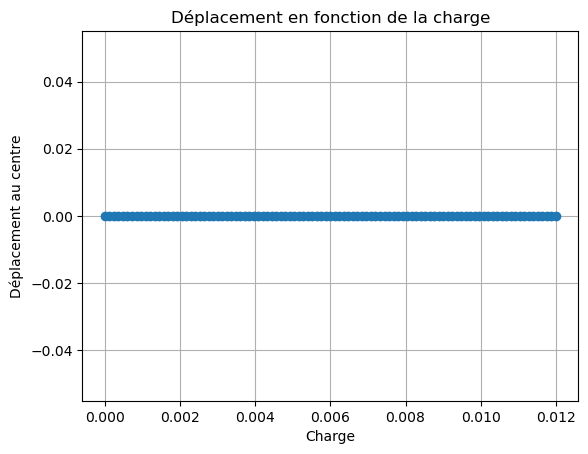

In [19]:
# Définir et résoudre le problème non linéaire
problem = NonlinearProblem(energy_u, u, bcs, J=energy_uu)
solver = NewtonSolver(MPI.COMM_WORLD, problem)

# Augmenter le nombre d'itérations et ajuster la tolérance si nécessaire
solver.atol = 1e-6
solver.rtol = 1e-6
solver.max_it = 1000

# Définir la charge croissante
loadings = np.linspace(0, L2 / 10.0, 101)
out = np.zeros_like(loadings)

# Fichier de sortie pour Paraview
xdmf_file = io.XDMFFile(MPI.COMM_WORLD, "disp.xdmf", "w")
xdmf_file.write_mesh(domain)

# Boucle de chargement
for (i, load) in enumerate(loadings):
    u_D2.vector.set(0.0)
    u_D2.interpolate(lambda x: np.vstack((np.zeros_like(x[0]), -load * np.ones_like(x[0]))))
    bc2 = fem.dirichletbc(u_D2, bc2_dofs)

    try:
        # Résoudre le problème
        n_iter, converged = solver.solve(u)
        if not converged:
            print(f"Load step {i}, load {load}: Solver did not converge")
            break

        # Enregistrer le déplacement au centre du domaine
        point = np.array([[L1 / 2, L2 / 2, 0]])
        cell_candidates = mesh.locate_entities(domain, domain.topology.dim, lambda x: np.isclose(x[0], L1 / 2) & np.isclose(x[1], L2 / 2))
        cell = cell_candidates[0] if cell_candidates.size > 0 else -1
        outdisp = u.eval(point, cell)
        out[i] = outdisp[1]

        # Enregistrer la solution dans le fichier XDMF
        xdmf_file.write_function(u, load)
    except RuntimeError as e:
        print(f"Erreur de résolution à l'étape de charge {i}, charge {load} : {e}")
        break

xdmf_file.close()

# Visualisation du résultat final
plotter = pv.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(domain)
grid = pv.UnstructuredGrid(topology, cell_types, geometry)
grid.point_data["Displacement"] = u.x.array.reshape((geometry.shape[0], 2))
warped = grid.warp_by_scalar("Displacement", factor=1.0)
plotter.add_mesh(warped, show_edges=True)
plotter.add_text("Déformée du maillage", font_size=12, color="grey", position="upper_edge")
plotter.show_bounds(color="grey")
plotter.add_axes(color="grey")
plotter.set_background("black")
plotter.show()

# Tracer le déplacement en fonction de la charge
import matplotlib.pyplot as plt
plt.plot(loadings, out, marker='o')
plt.xlabel('Charge')
plt.ylabel('Déplacement au centre')
plt.title('Déplacement en fonction de la charge')
plt.grid(True)
plt.show()

In [20]:
# Visualisation du résultat final
plotter = pv.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(domain)
grid = pv.UnstructuredGrid(topology, cell_types, geometry)
grid.point_data["Displacement"] = u.x.array.reshape((geometry.shape[0], 2))
warped = grid.warp_by_scalar("Displacement", factor=1.0)
plotter.add_mesh(warped, show_edges=True)
plotter.add_text("Déformée du maillage", font_size=12, color="grey", position="upper_edge")
plotter.show_bounds(color="grey")
plotter.add_axes(color="grey")
plotter.set_background("black")
plotter.show()

Widget(value='<iframe src="http://localhost:62320/index.html?ui=P_0x16d1f6510_2&reconnect=auto" class="pyvista…

In [21]:
plotter.view_xy() # Vue XY (vue par défaut)

In [ ]:
# Tracer le déplacement en fonction de la charge
import matplotlib.pyplot as plt
plt.plot(loadings, out, marker='o')
plt.xlabel('Charge')
plt.ylabel('Déplacement au centre')
plt.title('Déplacement en fonction de la charge')
plt.grid(True)
plt.show()

In [22]:
import numpy as np
print(np.linspace(0, 0.12 / 10.0, 101))

[0.      0.00012 0.00024 0.00036 0.00048 0.0006  0.00072 0.00084 0.00096
 0.00108 0.0012  0.00132 0.00144 0.00156 0.00168 0.0018  0.00192 0.00204
 0.00216 0.00228 0.0024  0.00252 0.00264 0.00276 0.00288 0.003   0.00312
 0.00324 0.00336 0.00348 0.0036  0.00372 0.00384 0.00396 0.00408 0.0042
 0.00432 0.00444 0.00456 0.00468 0.0048  0.00492 0.00504 0.00516 0.00528
 0.0054  0.00552 0.00564 0.00576 0.00588 0.006   0.00612 0.00624 0.00636
 0.00648 0.0066  0.00672 0.00684 0.00696 0.00708 0.0072  0.00732 0.00744
 0.00756 0.00768 0.0078  0.00792 0.00804 0.00816 0.00828 0.0084  0.00852
 0.00864 0.00876 0.00888 0.009   0.00912 0.00924 0.00936 0.00948 0.0096
 0.00972 0.00984 0.00996 0.01008 0.0102  0.01032 0.01044 0.01056 0.01068
 0.0108  0.01092 0.01104 0.01116 0.01128 0.0114  0.01152 0.01164 0.01176
 0.01188 0.012  ]
